In [1]:
!git clone https://github.com/tareknaous/readme.git

Cloning into 'readme'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 6), reused 23 (delta 0), pack-reused 0
Receiving objects: 100% (47/47), 1.95 MiB | 5.71 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np

In [3]:
language = 'en'
data_train = pd.concat([pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_train.xlsx'), pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_val.xlsx')], axis=0)
data_val = pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_test.xlsx')

In [4]:
n_labels = len(np.unique(data_train['Rating']))
label_dict = {}

for label in np.unique(data_train['Rating']):
    label_dict[label] = label-1

In [5]:
n_labels

6

In [6]:
train = pd.DataFrame(columns=['text', 'label'])
train['text'] = data_train['Sentence']
train['label'] = data_train['Rating'].replace(label_dict)

val = pd.DataFrame(columns=['text', 'label'])
val['text'] = data_val['Sentence']
val['label'] = data_val['Rating'].replace(label_dict)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    train['text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val['text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train['label'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val['label'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=n_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 10

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = list(label_dict.keys()) #['Easy', 'Normal']
    #label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


def metrics_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)

    for label in np.unique(labels_flat):
        # True Positives
        TP = cm[label, label]
        # False Positives: sum of the corresponding column minus TP
        FP = np.sum(cm[:, label]) - TP
        # False Negatives: sum of the corresponding row minus TP
        FN = np.sum(cm[label, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {TP}/{TP+FN} (True Positives / Total Actual Positives)')
        tqdm.write(f'Precision: {precision:.2f}')
        tqdm.write(f'Recall: {recall:.2f}')
        tqdm.write(f'F1 Score: {f1:.2f}\n')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/253 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.300038576832873
Validation loss: 1.1051682472229003
F1 Score (Weighted): 0.4726305730915995


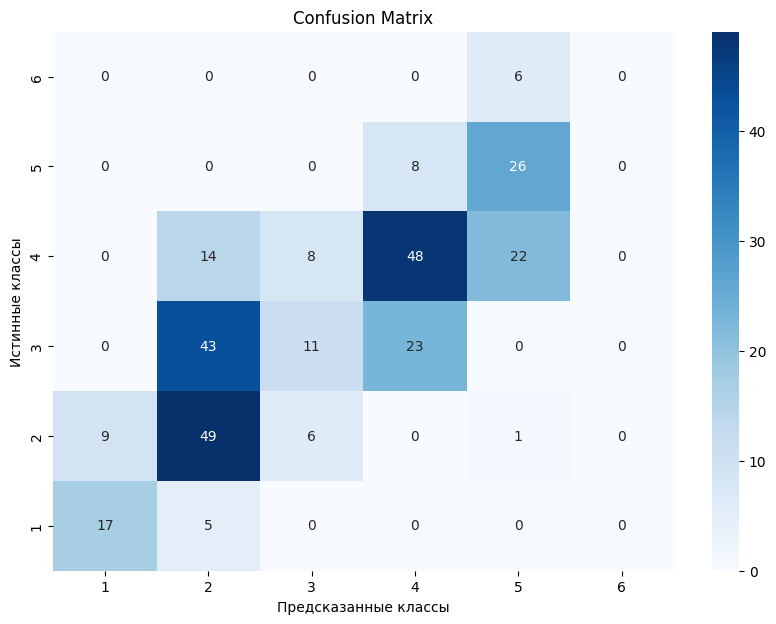

Class: 1
Accuracy: 17/22 (True Positives / Total Actual Positives)
Precision: 0.65
Recall: 0.77
F1 Score: 0.71

Class: 2
Accuracy: 49/65 (True Positives / Total Actual Positives)
Precision: 0.44
Recall: 0.75
F1 Score: 0.56

Class: 3
Accuracy: 11/77 (True Positives / Total Actual Positives)
Precision: 0.44
Recall: 0.14
F1 Score: 0.22

Class: 4
Accuracy: 48/92 (True Positives / Total Actual Positives)
Precision: 0.61
Recall: 0.52
F1 Score: 0.56

Class: 5
Accuracy: 26/34 (True Positives / Total Actual Positives)
Precision: 0.47
Recall: 0.76
F1 Score: 0.58

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 2:   0%|          | 0/253 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9887975680498267
Validation loss: 0.9674817393223445
F1 Score (Weighted): 0.5880895099915214


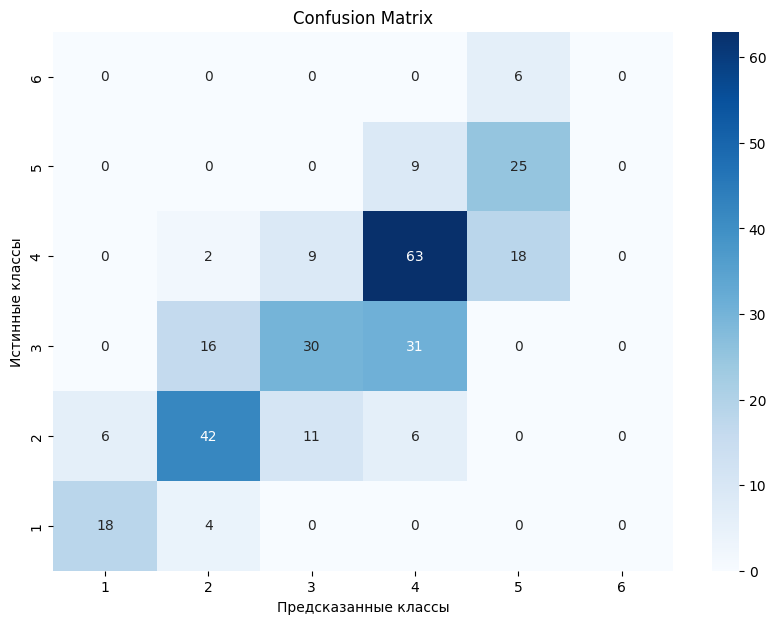

Class: 1
Accuracy: 18/22 (True Positives / Total Actual Positives)
Precision: 0.75
Recall: 0.82
F1 Score: 0.78

Class: 2
Accuracy: 42/65 (True Positives / Total Actual Positives)
Precision: 0.66
Recall: 0.65
F1 Score: 0.65

Class: 3
Accuracy: 30/77 (True Positives / Total Actual Positives)
Precision: 0.60
Recall: 0.39
F1 Score: 0.47

Class: 4
Accuracy: 63/92 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.68
F1 Score: 0.63

Class: 5
Accuracy: 25/34 (True Positives / Total Actual Positives)
Precision: 0.51
Recall: 0.74
F1 Score: 0.60

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 3:   0%|          | 0/253 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8382026018361329
Validation loss: 0.9592220932245255
F1 Score (Weighted): 0.5733897690794243


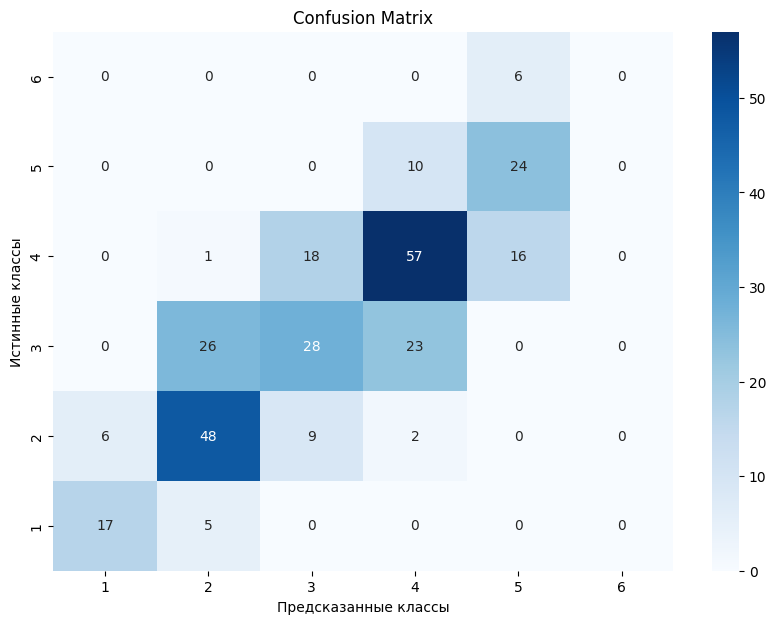

Class: 1
Accuracy: 17/22 (True Positives / Total Actual Positives)
Precision: 0.74
Recall: 0.77
F1 Score: 0.76

Class: 2
Accuracy: 48/65 (True Positives / Total Actual Positives)
Precision: 0.60
Recall: 0.74
F1 Score: 0.66

Class: 3
Accuracy: 28/77 (True Positives / Total Actual Positives)
Precision: 0.51
Recall: 0.36
F1 Score: 0.42

Class: 4
Accuracy: 57/92 (True Positives / Total Actual Positives)
Precision: 0.62
Recall: 0.62
F1 Score: 0.62

Class: 5
Accuracy: 24/34 (True Positives / Total Actual Positives)
Precision: 0.52
Recall: 0.71
F1 Score: 0.60

Class: 6
Accuracy: 0/6 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



Epoch 4:   0%|          | 0/253 [00:00<?, ?it/s]

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = 'cuda'

model = model.to(device)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    #accuracy_per_class(predictions, true_vals)
    plot_confusion_matrix(predictions, true_vals, label_dict)
    metrics_per_class(predictions, true_vals, label_dict)

In [13]:
torch.save(model.state_dict(), "./model_en")

In [ ]:
language = 'ru'
data_test = pd.concat([pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_train.xlsx'), pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_val.xlsx'), pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_test.xlsx')], axis=0)
data_test.head()

In [53]:
test = pd.DataFrame(columns=['text', 'label'])
test['text'] = data_test['Sentence'][data_test['Sentence'].apply(lambda x: isinstance(x, str))]
test['label'] = data_test['Rating'][data_test['Sentence'].apply(lambda x: isinstance(x, str))].replace(label_dict)

In [54]:
encoded_data_predict = tokenizer.batch_encode_plus(
    test['text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_predict = encoded_data_predict['input_ids']
attention_masks_predict = encoded_data_predict['attention_mask']
labels_predict = torch.tensor(test['label'].values)

dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [55]:
batch_size = 10

dataloader_predict = DataLoader(dataset_predict,
                              sampler=RandomSampler(dataset_predict),
                              batch_size=batch_size)

Predictions loss: 2.15278711034493
F1 Score (Weighted): 0.18234108196142404


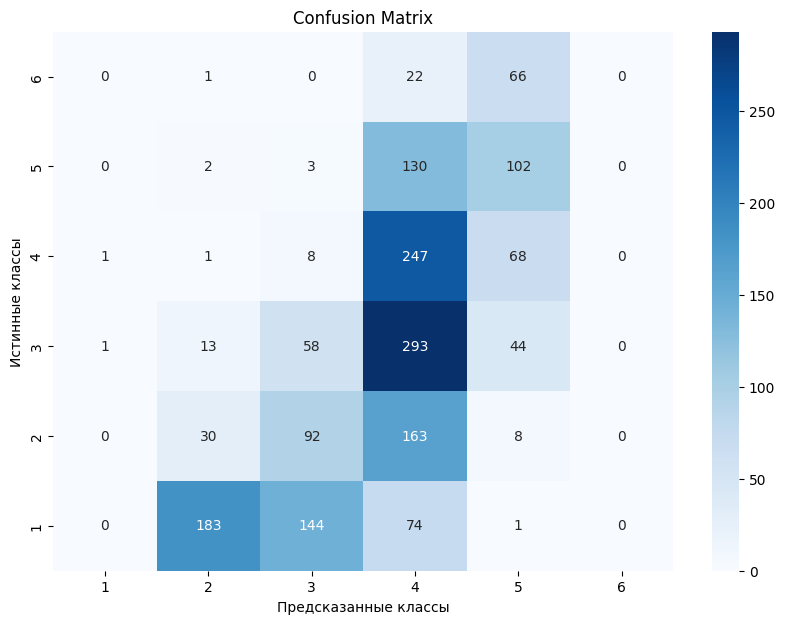

Class: 1
Accuracy: 0/402 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class: 2
Accuracy: 30/293 (True Positives / Total Actual Positives)
Precision: 0.13
Recall: 0.10
F1 Score: 0.11

Class: 3
Accuracy: 58/409 (True Positives / Total Actual Positives)
Precision: 0.19
Recall: 0.14
F1 Score: 0.16

Class: 4
Accuracy: 247/325 (True Positives / Total Actual Positives)
Precision: 0.27
Recall: 0.76
F1 Score: 0.39

Class: 5
Accuracy: 102/237 (True Positives / Total Actual Positives)
Precision: 0.35
Recall: 0.43
F1 Score: 0.39

Class: 6
Accuracy: 0/89 (True Positives / Total Actual Positives)
Precision: 0.00
Recall: 0.00
F1 Score: 0.00



In [56]:
predict_loss, predictions, true_predict = evaluate(dataloader_predict)
predict_f1 = f1_score_func(predictions, true_predict)
print(f'Predictions loss: {predict_loss}')
print(f'F1 Score (Weighted): {predict_f1}')
plot_confusion_matrix(predictions, true_predict, label_dict)
metrics_per_class(predictions, true_predict, label_dict)